# 1. Import Libraries Needed
---

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from wordcloud import WordCloud
from pprint import pprint

import string
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')
#pd.set_option('display.max_colwidth', None)
%matplotlib inline

# 2. Read the Dataset
---

In [2]:
df = pd.read_csv('data/data_preprocessed.csv')

In [79]:
df.sample(5)

,tweet_id,created_at,author_id,username,text,reference_type,text_cleaned
26044,1643275087532138498,2023-04-04T15:31:26.000Z,1074412789089746946,Sirambutmerah_,Program ini sejalan dengan roadmap percepatan ...,NaN,Program ini sejalan dengan roadmap percepatan ...
23050,1648204415139184648,2023-04-18T05:58:49.000Z,1577596673190400000,RyanCaesar18,@Pratama84413515 @WulingMotorsID Air EV tuh da...,['replied_to'],Air EV tuh dalam nya nyaman banget
14507,1637457646503755776,2023-03-19T14:15:00.000Z,1630442630437015553,kaynaraaa,PLN terus mendukung program pemerintah. Dalam ...,NaN,PLN terus mendukung program pemerintah. Dalam ...
2531,1616400969524482048,2023-01-20T11:43:17.000Z,4895949967,karimnas_,Pemerintah kalau memang peduli pada isu lingku...,['quoted'],Pemerintah kalau memang peduli pada isu lingku...
22835,1648682903088558082,2023-04-19T13:40:09.000Z,1635883027799904258,satriaonly1,"Senyap tapi bertenaga, sepeda motor listrik me...",NaN,"Senyap tapi bertenaga, sepeda motor listrik me..."


In [80]:
df.shape

(31111, 7)

In [13]:
original_tweet = df.text.values.tolist()
cleaned_tweet = df.text_cleaned.values.tolist()

In [3]:
df['created_at'] = df['created_at'].apply(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%f%z').strftime('%d-%m-%Y'))
df['reference_type'] = df['reference_type'].fillna("['original']")

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31111 entries, 0 to 31110
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweet_id        31111 non-null  int64 
 1   created_at      31111 non-null  object
 2   author_id       31111 non-null  int64 
 3   username        31111 non-null  object
 4   text            31111 non-null  object
 5   reference_type  31111 non-null  object
 6   text_cleaned    31111 non-null  object
dtypes: int64(2), object(5)
memory usage: 1.7+ MB


In [83]:
df.isna().sum()

tweet_id          0
created_at        0
author_id         0
username          0
text              0
reference_type    0
text_cleaned      0
dtype: int64

# 3. Tokenization
---

In [4]:
df['tokenized'] = df['text_cleaned'].apply(lambda x: word_tokenize(x))

# 4. Exploratory Data Analysis
---

## 4.1. Account Analysis

In [85]:
# Amount of users
df['author_id'].nunique()

13645

In [31]:
# Top Accounts
accounts = pd.DataFrame(df.groupby(['author_id','username'])['author_id'].count().sort_values(ascending=False).reset_index(name='count'))
top_accounts = accounts[accounts['count'] >= 25]

In [32]:
add_top_accounts = accounts[accounts['count'].between(20,24)]

In [33]:
fig = px.bar(top_accounts, x='username', y='count', text_auto=True, title="Top User Accounts",color_discrete_sequence=['#174876'])
fig.update_traces(textfont_size=12, textangle=0, textposition="inside", cliponaxis=False)
fig.show()

As we can see, there are a lot of tweets coming from news media accounts. Therefore, we want to exclude all the tweets from these top 50 accounts.

### 4.1.1. Delete Tweets from News Media Accounts

In [12]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Table(
    header=dict(values=list(top_accounts.columns),
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[top_accounts.author_id, top_accounts.username, top_accounts['count']],
               fill_color='lavender',
               align='left'))
])

fig.show()

In [25]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Table(
    header=dict(values=list(add_top_accounts.columns),
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[add_top_accounts.author_id, add_top_accounts.username, add_top_accounts['count']],
               fill_color='lavender',
               align='left'))
])

fig.show()

In [34]:
news_accounts = list(top_accounts['username'])
non_newsAccounts = {'aliefwikarta','wellylie99','lucasxyzz','el_raffasya','faris_sina','AmFirdau5','suci_ci7','maevexael','Ramaaadhaaan',
                    'Naurapss','MegaPitru','laagerhei96332','rina_novitasari','sherlyn4e','chiaraaurellie','nadyanti17','plwhemvvzhihny',
                    'RaniSuper2','elisa_jkt','shinnyyy91','sqeezte','Rizkiraa05','fjrantt','clarettariella','Supianoor19','PiwPiw8164',
                    'rismaaoneng','ch_sasya','AjoSiam','p0kachuu'} #keep the non news accounts
news_accounts = [uname for uname in news_accounts if uname not in non_newsAccounts]

In [35]:
add_news_accounts = ['KontanNews','kuatbacacom','WikiDPR2','SahabatPLNJkt','_pln_id','pln_uid_s2jb','Beritabaruco','ota_production','beritaKBR','apahabarmedia','SINDOnews','lantakanemas']

In [36]:
news_accounts += add_news_accounts

In [37]:
print('Total Accounts Removed:',len(news_accounts),'acounts')

Total Accounts Removed: 85 acounts


In [38]:
df_filtered1 = df[~df['username'].isin(news_accounts)]

In [39]:
print('Total tweets after excluding the news media accounts:',df_filtered1.shape[0],'tweets')

Total tweets after excluding the news media accounts: 24195 tweets


## 4.2. Term Frequency Analysis

In [99]:
words = df_filtered1['tokenized']
list_of_words = []
for wordlist in words:
    list_of_words += wordlist
    
new_list_of_words = [''.join(char for char in item
                        if char not in string.punctuation)
                    for item in list_of_words if item != '']

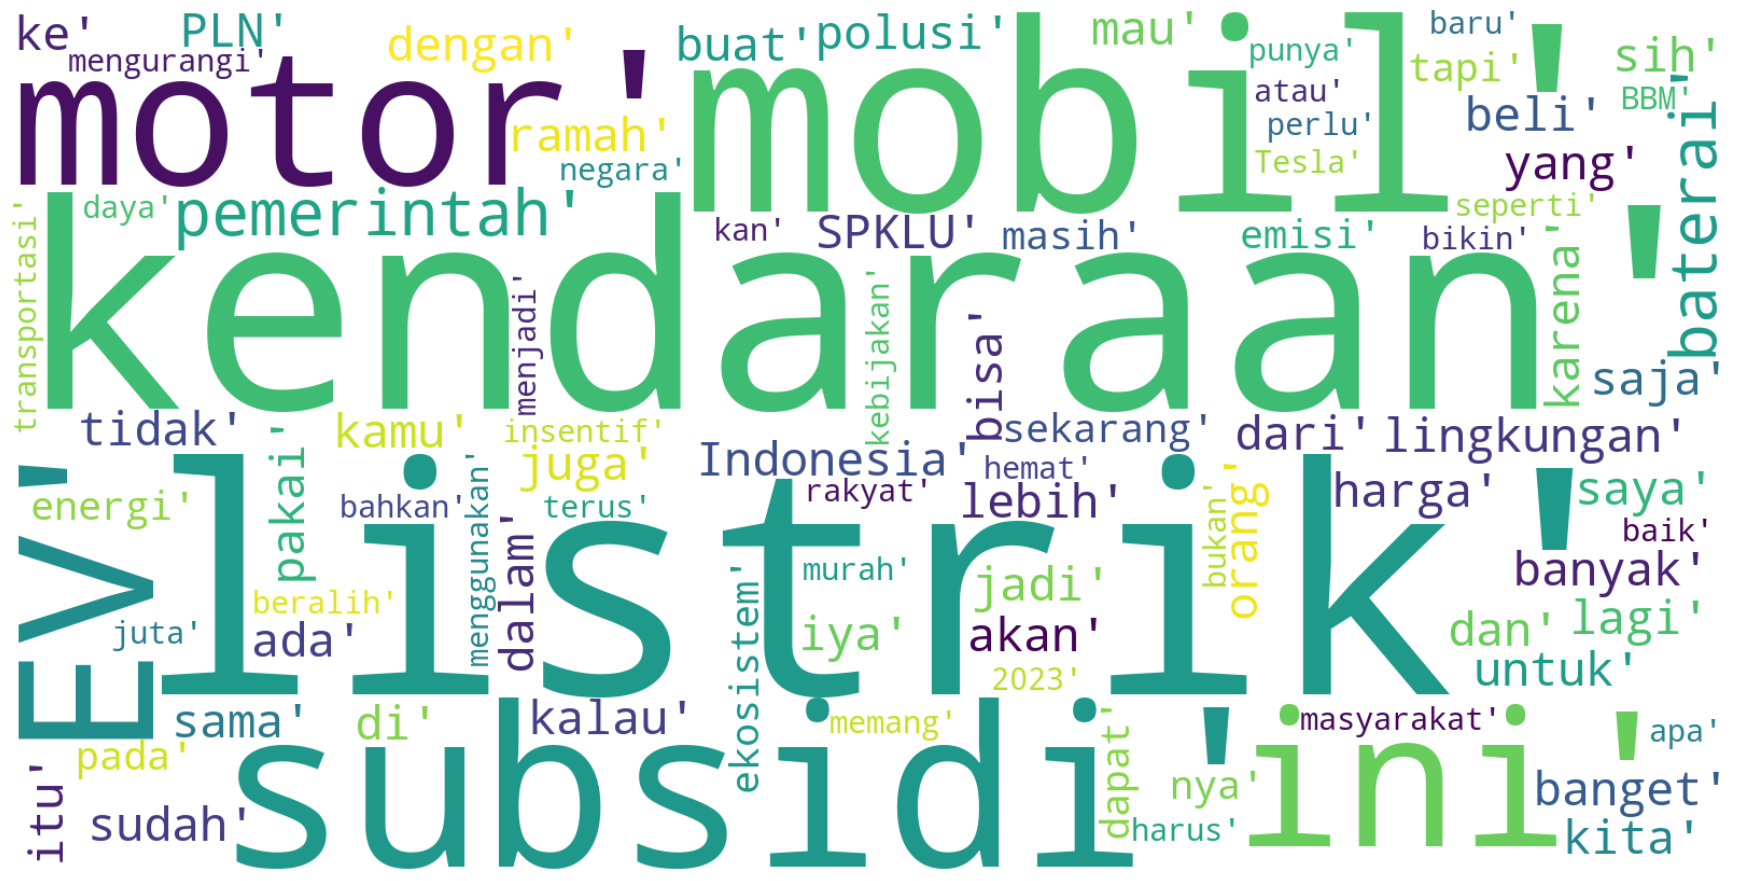

In [100]:
mostcommon = FreqDist(new_list_of_words).most_common(100)
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(str(mostcommon))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
#plt.title('Top 100 Most Common Words', fontsize=100)
plt.tight_layout(pad=5)
plt.show()

## 4.3. Word Count Distribution

In [40]:
df_filtered1['tweet_word_count'] = df_filtered1['text_cleaned'].astype('str').str.count(' ')

print(df_filtered1.tweet_word_count.describe())

count    24195.000000
mean        20.873610
std         11.083829
min          0.000000
25%         12.000000
50%         19.000000
75%         29.000000
max         61.000000
Name: tweet_word_count, dtype: float64


In [41]:
# word count distribution
N = 5
print('{} documents in total'.format(df_filtered1.shape[0]))
print('{} documents have fewer than {N} words'.format(df_filtered1[df_filtered1.tweet_word_count<N].shape[0], N = N))
print('{}% documents have fewer than {N} words'.format(round(df_filtered1[df_filtered1.tweet_word_count<N].shape[0]/df_filtered1.shape[0]*100, 1), N = N))

fig = px.histogram(df_filtered1, x="tweet_word_count", title="Tweets Word Count Distribution",color_discrete_sequence=['#174876'])
fig.show()

24195 documents in total
425 documents have fewer than 5 words
1.8% documents have fewer than 5 words


We want to delete the tweets that have fewer than 5 words.

In [42]:
df_filtered2 = df_filtered1[(df_filtered1['tweet_word_count'] >= 5) & (df_filtered1['tweet_word_count'] <= 50)]

In [43]:
df_filtered2.shape

(23729, 9)

In [44]:
# Save the filtered dataset
df_filtered2.to_csv('data/data_filtered.csv', index=False)